## IDENTIFICATION OF NOVEL CLASSES OF NEOANTIGENS IN CANCER | Data preprocessing

In [1]:
%load_ext rpy2.ipython

## 0. Data preparation

This first cell should be modified according to the data that is going to be used. It is only available for datasets with paired samples per patient: normal and tumor. 

The **PROJECT** variable should be changed according to the GEO identifier.

From the GEO website, the *SRR_Acc_List.txt* and *SraRunTable.txt* files should be manually downloaded and save in a directory. This directory should be specified in **SRR** variable.

The pipeline is developed with the intention of running the most computationally expensive programs in a cluster. 
In this case, a Gluster File System has been used. The code to run on a cluster may need to be adapted.

In [ ]:
import os,re,shutil,glob,openpyxl
import pandas as pd
from Bio import SeqIO
from gtfparse import read_gtf
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
from IPython.display import Image

PROJECT="GSE193567"

DIR=os.path.join("data",PROJECT)

try:
    os.makedirs(DIR) #path where to store all the itermediate steps and outputs of the pipeline
except:
    print("Directory for %s already exists" %PROJECT)
    
CLUSTERDIR="/users/genomics/marta" #path where to run and store things that run in a cluster
SRR="/projects_eg/datasets/"+PROJECT # path where SRR_Acc_List.txt and SraRunTable.txt are stored. It should be inside a folder named with GEO accession
SRR_ACC=os.path.join(SRR,"SRR_Acc_List.txt") 
SRA=os.path.join(SRR,"SraRunTable.txt")

FASTQDIR=os.path.join(DIR,"fastq_files") #path where to store fastq files
try:
    os.mkdir(FASTQDIR)
except:
    print("Fastq_files directory exists")
    
shutil.copy(SRR_ACC, os.path.join(FASTQDIR,"SRR_Acc_List.txt"))
shutil.copy(SRA, os.path.join(FASTQDIR,"SraRunTable.txt"))

GENOMEDIR="genomes"

try:
    os.makedirs(os.path.join(DIR,"analysis"))
    os.makedirs(os.path.join(DIR,"results"))
    #os.makedirs(os.path.join(DIR,"scripts"))
except:
    print("Directory exists")



In [ ]:
%%R

require(tidyr)
require(dplyr)
require(rtracklayer)
#library(purrr)
require(ggplot2)
require(RColorBrewer)
require(devtools)
require(stringr)
require(edgeR)

Get a three column file with patient_id normal_id tumor_id for latter usage 

In [4]:
metadata = pd.read_csv(os.path.join(FASTQDIR.split("/fastq_files")[0],"SraRunTable.txt"))
metadata = metadata[['Run','Individual','tissue']]

normal = metadata[metadata['tissue'] == "non-tumor"]
normal = normal[['Individual','Run']]

tumor = metadata[metadata['tissue'] == "tumor"]
tumor = tumor[['Individual','Run']].rename(columns ={'Run' : 'Run_t'})

patients = pd.merge(normal, tumor, on=['Individual'])
patients['Individual'] = patients['Individual'].str.split(' ').str[1]
patients.to_csv(os.path.join(DIR,"results/patients.csv"),index=False, header=False)
patients_summary = os.path.join(DIR,"results/patients.csv")

patients_id=list(patients.iloc[:,0])
normal_id=list(patients.iloc[:,1])
tumor_id=list(patients.iloc[:,2])

patients

,Individual,Run,Run_t
0,10615,SRR17593537,SRR17593538
1,10594,SRR17593539,SRR17593540
2,10584,SRR17593542,SRR17593541
3,10635,SRR17593543,SRR17593544
4,10632,SRR17593546,SRR17593545
5,10628,SRR17593548,SRR17593547
6,10627,SRR17593550,SRR17593549
7,10622,SRR17593551,SRR17593552
8,10619,SRR17593554,SRR17593553


## 10.HLAtyping

The programm needs a fasta file and if it is rna or dna and then it first only takes the parts of chromosome 6 that encode the HLA-I and gives you predictions. I ran it with --enumerations 3, so it gives the three most likely predictions. But in the end I only used the best prediction. And I have several samples per patient. So what I did is run it for all (tumour DNA, blood DNA, tumour RNA, post-treatment samples etc), took only the best predcition and checked if it is the same HLA Allele Typing in all samples (whcih it should be). And when it was different between samples of the same patient, I looked at the quality (coverage plots provided by the program) and then it was ususally quite clear that for samples where the prediction differed the coverage was low...

https://github.com/nf-core/hlatyping

In [ ]:
%%bash -s "$DIR"

mkdir $1/analysis/10_HLAtyping

In [ ]:
%%bash -s "$PROJECT" "$FASTQDIR" "$CLUSTERDIR" "$DIR" "$patients_summary"

######################################DONE IN CLUSTER###############################################

sbatch $3/scripts/4_neoantigens_prediction/loop_hla.sh $1 $2 $3 $4 $5

To generate HLA alleles file from the specific dataset and for its latter usage in netMHCpan

In [20]:
out_df = pd.DataFrame()
counter=0
OUT=DIR+"/analysis/10_HLAtyping/hla_alleles_patients.csv"
with open(OUT, 'w') as out:
    for p in patients_id:
        out_df = pd.DataFrame()
        with open (DIR+"/analysis/10_HLAtyping/"+p+"/optitype/"+normal_id[counter]+"/"+normal_id[counter]+"_result.tsv") as hlatyping:
            lines = hlatyping.readlines()
            del lines[0]
            line = lines[1].strip()
            splitted_line = line.split("\t")
            del splitted_line[0]
            del splitted_line[6]
            del splitted_line[6]
            listToStr = '\t'.join(map(str, splitted_line))
            listToStr = listToStr.strip()
            out.write("%s\t%s\n" %(p, listToStr))
        
        counter = counter + 1
    


In [21]:
%%bash -s "$DIR"

hlatyping=$1/analysis/10_HLAtyping/hla_alleles_patients.csv

cut -d, -f2- $hlatyping > ${hlatyping%%_patients*}.csv
< ${hlatyping%%_patients*}.csv tr -s '\t' '\n' | sort | uniq > ${hlatyping%%_patients*}_uniq.csv

sed -i -e 's/^/HLA-/' ${hlatyping%%_patients*}_uniq.csv 

< ${hlatyping%%_patients*}_uniq.csv tr -s '\n' ',' > $1/analysis/10_HLAtyping/alleles.txt
sed -i 's/\*//g' $1/analysis/10_HLAtyping/alleles.txt

In [22]:
#HLA alleles separated by , to pass to netMHCpan directly
alleles=DIR+"/analysis/10_HLAtyping/hla_alleles_patients.csv"
#the file will contain all the HLA I alleles per patient written in such a way that no further cleaning is need for netMHCpan to use them
for p in patients_id:
    OUT=DIR+"/analysis/10_HLAtyping/"+p+"_alleles_to_netMHCpan.csv"
    with open(OUT, 'w') as out:
        with open(alleles) as inp:
            lines=inp.readlines()
            for line in lines:
                line = line.strip()
                splitted_line=line.split("\t")
                patient=splitted_line.pop(0)
                if patient == p:
                    listToStr = ',HLA-'.join(map(str, splitted_line))
                    listToStr = listToStr.replace("*","")
                    out.write("HLA-"+listToStr+"\n")


A*02:01,HLA-A*29:10,HLA-B*44:03,HLA-B*44:03,HLA-C*16:01,HLA-C*16:01
A02:01,HLA-A29:10,HLA-B44:03,HLA-B44:03,HLA-C16:01,HLA-C16:01
A*02:01,HLA-A*30:02,HLA-B*44:03,HLA-B*44:22,HLA-C*05:01,HLA-C*16:01
A02:01,HLA-A30:02,HLA-B44:03,HLA-B44:22,HLA-C05:01,HLA-C16:01
A*02:01,HLA-A*02:29,HLA-B*35:01,HLA-B*49:01,HLA-C*04:01,HLA-C*07:01
A02:01,HLA-A02:29,HLA-B35:01,HLA-B49:01,HLA-C04:01,HLA-C07:01
A*11:01,HLA-A*32:01,HLA-B*35:08,HLA-B*49:01,HLA-C*04:01,HLA-C*07:01
A11:01,HLA-A32:01,HLA-B35:08,HLA-B49:01,HLA-C04:01,HLA-C07:01
A*32:01,HLA-A*32:01,HLA-B*35:03,HLA-B*44:03,HLA-C*04:01,HLA-C*16:01
A32:01,HLA-A32:01,HLA-B35:03,HLA-B44:03,HLA-C04:01,HLA-C16:01
A*11:01,HLA-A*24:10,HLA-B*08:01,HLA-B*38:01,HLA-C*07:01,HLA-C*12:03
A11:01,HLA-A24:10,HLA-B08:01,HLA-B38:01,HLA-C07:01,HLA-C12:03
A*01:01,HLA-A*30:01,HLA-B*08:01,HLA-B*49:01,HLA-C*07:01,HLA-C*12:03
A01:01,HLA-A30:01,HLA-B08:01,HLA-B49:01,HLA-C07:01,HLA-C12:03
A*01:01,HLA-A*30:02,HLA-B*08:01,HLA-B*18:01,HLA-C*07:01,HLA-C*05:09
A01:01,HLA-A30:02,HLA-

## 11.PeptideBindingMHC



To choose the length of the peptides, we analyzed the Supplementary Table S3 of 

Chong, C., Müller, M., Pak, H. et al. Integrated proteogenomic deep sequencing and analytics accurately identify non-canonical peptides in tumor immunopeptidomes. Nat Commun 11, 1293 (2020). https://doi.org/10.1038/s41467-020-14968-9

We used it as a kind of database to support our findings.

In [ ]:
%%bash -s "$GENOMEDIR"
mkdir $1/chongetal
cd $1/chongetal

wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-14968-9/MediaObjects/41467_2020_14968_MOESM5_ESM.xlsx

In [ ]:
#abundance 8/9/10/11 aa peptides
chong = pd.read_excel(os.path.join(GENOMEDIR,"/chonetal/Chong_etal_2020_SupData3_41467_2020_14968_MOESM5_ESM.xlsx", skiprows=1)
chong['Transcript_ID'] = chong['Transcript_ID'].str[:-2]
list_seqs = chong.Sequence.values.tolist()
total_num_peptides=len(list_seqs)
counter8 = 0
counter9 = 0
counter10 = 0
counter11 = 0

for peptide in list_seqs:
    if len(peptide) == 8:
        counter8 = counter8 + 1
    if len(peptide) == 9:
        counter9 = counter9 + 1
    if len(peptide) == 10:
        counter10 = counter10 + 1
    if len(peptide) == 11:
        counter11 = counter11 + 1

print("There are:\n%i 8aa peptides\n%i 9aa peptides\n%i 10aa peptides\n%i 11aapeptides" %(counter8,counter9,counter10,counter11))

9aa peptides are the ones with more binding affinity, according to Chong et al. Supplementary Table S3. So we are going to use 9aa peptides.

To be able to jump to conclusions and compare results, we will predict the binding affinity of peptides derived from several strategies:

**A** | due to expression of tumor-specific putative noncanonical ORFS (CIPHER)


In [50]:
try:
    os.makedirs(DIR+"/analysis/11_PeptideBindingMHC/noncanonical_CIPHER")
except:
    print("Directory already exists")
    
for p in patients_id:
    INDIR=DIR+"/analysis/09_CIPHER/"+p
    OUTDIR=DIR+"/analysis/11_PeptideBindingMHC/noncanonical_CIPHER/"+p
    try:
        os.mkdir(OUTDIR)
    except:
        print("Directory already exists, data could be overwritten.")
    file= p + "_noncanonical_all_orfs_FPKM1_notduplis_PROTEIN.fa" 
    outfile = file[:-3] + "_9aa.fa"
    with open (os.path.join(OUTDIR,outfile), 'w') as out:
        for seq_record in SeqIO.parse(os.path.join(INDIR,file), "fasta"):
            if len(seq_record.seq) >= 9: # we keep only sequences with > 9 aminoacids so they can be cut into little peptides. Really small sequences with less than 9 aa would not bind to the MHC.
                out.write(">" + seq_record.id + "\n" + str(seq_record.seq) + "\n")
            else:
                next


Directory already exists
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.
Directory already exists, data could be overwritten.


Summary file with the amount of sequences with more than 9aa with respect to the total

In [5]:
%%bash -s "$DIR" "$patients_summary"

OUT=$1/results/sequences_9aa.txt
if [ -f "$OUT" ] ; then
    rm "$OUT"
fi
cat $2 | while IFS=, read p normal tumor; do
INDIR=$1/analysis/09_CIPHER/${p}
LONG_DIR=$1/analysis/11_PeptideBindingMHC/noncanonical_CIPHER/${p}
echo -e ${p}" full_length: "$(grep '>' ${INDIR}/${p}_noncanonical_all_orfs_FPKM1_notduplis_PROTEIN.fa | wc -l) >> $OUT
echo -e ${p}" more than 9 aa: "$(grep '>' ${LONG_DIR}/${p}_noncanonical_all_orfs_FPKM1_notduplis_PROTEIN_9aa.fa | wc -l) >> $OUT
done

In [6]:
#clean header
for p in patients_id:
    INDIR=DIR+"/analysis/11_PeptideBindingMHC/noncanonical_CIPHER/"+p
    for file in os.listdir(INDIR):
        if file.endswith("9aa.fa"):
            outfile = file[:-3] + "_cleanheader.fa"

            with open (os.path.join(INDIR,outfile), 'w') as out:
                for seq_record in SeqIO.parse(os.path.join(INDIR,file), "fasta"):
                    if "ENST" in seq_record.id:
                        identifier = seq_record.id.split(".")[0]
                        identifier = identifier + ";" + seq_record.id[-1]
                    else:
                        identifier = seq_record.id.split(",")[0]
                        identifier = identifier[:-2] + ";" + seq_record.id[-1]

                    out.write(">%s\n%s\n" %(str(identifier),str(seq_record.seq)))


**NetMHCpan**

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" 

######################################DONE IN CLUSTER###############################################

sbatch --array=1-9 $2/scripts/4_neoantigen_prediction/netmhcpan_noncanonical.sh $1 $2 $3 #--array=1-n where n is the number of files to process

**B** | Due to expression of tumor-specific canonical CDS

In [5]:
for p in patients_id:
    INDIR=DIR+"/analysis/08_tumor_specific/"+p
    file=p + "_known_tumor_specific_genes_1FPKM_300kb_CDS_gene.fa"
    outfile = file[:-3] + "_PROTEIN.fa"
    with open (os.path.join(INDIR,outfile), 'w') as out:
        for seq_record in SeqIO.parse(os.path.join(INDIR,file), "fasta"):
            identif=str(seq_record.id)
            sequence=str(seq_record.seq.translate())
            out.write(">" + identif + "\n" + sequence[:-1] + "\n")


/home/marta/.local/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


**NetMHCpan**

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" 

######################################DONE IN CLUSTER###############################################

sbatch --array=1-9 $2/scripts/4_neoantigen_prediction/netmhcpan_canonical.sh $1 $2 $3 #--array=1-n where n is the number of files to process

**C** | NOCDS with translation evidence

We have two sets of ribo-seq data to compare our finding with translation evidence. To do so, we compare at indetifier level, if what we considered as non-canonical with coding potential is supported by ribo seq data

*Ouspenskaia*

In [6]:
ouspenskaia=pd.read_csv(os.path.join(cwd,"riboseq_evidences/ouspenskaia.lncRNA.20220222.csv"))

for p in patients_id:
    try:
        os.makedirs(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p)
    except:
        print("Directory already exists, data may be overwritten")
        
    NOCDS=DIR+"/analysis/08_tumor_specific/"+p+"/"+p+"_known_tumor_specific_genes_1FPKM_300kb_NOCDS_selected.csv" # from all nocds tumor specific transcripts,
    OUTNOCDS=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+ p + "/" + p +"_translation_evidence_ouspenskaia.txt" #how many of them are present in ribo-seq set of data from Ouspenskaia
    OUTNOCDS_list=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+ p + "/" + p +"_translation_evidence_ouspenskaia_ids.txt" #and generate also a list

    df = pd.read_csv(NOCDS)
    list_df = df.gene_id.values.tolist()
    list_df_clean = [x.split(".")[0] for x in list_df]
    shared = ouspenskaia[ouspenskaia['gene'].isin(list_df_clean)]
    shared.to_csv(OUTNOCDS, index=False, header=True)
    shared.iloc[:,2].to_csv(OUTNOCDS_list, index=False, header=False)

Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten
Directory already exists, data may be overwritten


Generate a summary file with the number of non-protein coding genes present in ouspenskaia database

In [7]:
%%bash -s "$DIR" "$patients_summary"

OUT=$1/results/overlap_w_ouspenskaia.txt
if [ -f "$OUT" ] ; then
    rm "$OUT"
fi
cat $2 | while IFS=, read p normal tumor; do
    file=$1/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/${p}/${p}_translation_evidence_ouspenskaia_ids.txt
    echo -e $p"\t"$(wc -l < $file) >> $OUT 
done

*HCC*

In [9]:
hcc=pd.read_csv(os.path.join(cwd,"riboseq_evidences/HCC_tumor.lncRNA.20220222.csv"))

for p in patients_id:     
    NOCDS=DIR+"/analysis/08_tumor_specific/"+p+"/"+p+"_known_tumor_specific_genes_1FPKM_300kb_NOCDS_selected.csv"
    OUTNOCDS=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+ p + "/" + p +"_translation_evidence_hcc.txt"
    OUTNOCDS_list=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+ p + "/" + p +"_translation_evidence_hcc_ids.txt"

    df = pd.read_csv(NOCDS)
    list_df = df.gene_id.values.tolist()
    list_df_clean = [x.split(".")[0] for x in list_df]
    shared = hcc[hcc['gene'].isin(list_df_clean)]
    shared.to_csv(OUTNOCDS, index=False, header=True)
    shared.iloc[:,2].to_csv(OUTNOCDS_list, index=False, header=False)

Generate a summary file with the number of non-protein coding genes present in hcc 

In [10]:
%%bash -s "$DIR" "$patients_summary"

OUT=$1/results/overlap_w_hcc.txt
if [ -f "$OUT" ] ; then
    rm "$OUT"
fi
cat $2 | while IFS=, read p normal tumor; do
    file=$1/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/${p}/${p}_translation_evidence_hcc_ids.txt
    echo -e $p"\t"$(wc -l < $file) >> $OUT 
done

Concatenate both overlapping genes with the translation evidence datasets avoiding redundancies in such a way that we will be generating a file with those nonprotein coding genes we detected and with translation evidence.

In [11]:
%%bash -s "$DIR" "$patients_summary"

cat $2  | while IFS=, read p normal tumor; do
INDIR=$1/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/${p}
cat ${INDIR}/${p}*ids.txt | sort | uniq > ${INDIR}/${p}_translational_evidence.txt
echo -e $p"\t"$(wc -l < ${INDIR}/${p}_translational_evidence.txt) 

done

10615	3
10594	14
10584	4
10635	6
10632	3
10628	4
10627	2
10622	9
10619	10


Generate mini gtf of those lncRNA and pseudogenes tumor specific with coding potential according to two sources of RIbo-Seq data.

In [12]:
counter=0
for p in patients_id:
    print(p)
    REF=DIR+"/analysis/06_stringtie/stringtie_reference_annotations/"+tumor_id[counter]+"_reference_annotation_sorted.gtf"     
    with open(REF) as annotations:
        annotation_lines = annotations.readlines()
        csv_file=pd.read_csv(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translational_evidence.txt", header=None)
        g_id = []
        g_id = list(csv_file.iloc[:,0])
        OUT=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translational_evidence.gtf"

        with open(OUT, 'w') as out:
            for line in annotation_lines:
                if line.startswith('#'):
                    next
                else:
                    splitted_line = line.split(";")
                    ENST = splitted_line[1]
                    ENST = re.findall('"([^"]*)"', ENST)[0]
                    if ENST.split(".")[0] in g_id:
                        out.write(line)

    counter = counter + 1

 

10615
10594
10584
10635
10632
10628
10627
10622
10619


Get fasta sequence of open reading frames from CIPHER that have ribo-seq support

In [13]:
for p in patients_id:
    file=DIR+"/analysis/09_CIPHER/"+p+"/"+p+"_known_tumor_specific_genes_1FPKM_300kb_NOCDS_selected_8aa_cipher_all_orfs.fa"
    ids=list(pd.read_csv(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translational_evidence.txt", header=None).iloc[:,0])
    OUT=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translational_evidence.fa"
    with open(OUT, 'w') as out:
        for seq_record in SeqIO.parse(file, 'fasta'):
            if seq_record.id.split('.')[0] in ids:
                out.write(">%s\n%s\n" %(seq_record.id, seq_record.seq))

In [14]:
%%bash -s "$DIR" "$patients_summary"

cat $2 | while IFS=, read p normal tumor; do
file=$1/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/${p}/${p}_translational_evidence.fa
echo -e $p"\t"$(grep '>' $file | wc -l) #orfs
done

10615	6
10594	23
10584	8
10635	10
10632	2
10628	3
10627	0
10622	12
10619	8


PYTHON VENN DIAGRAMS PER PATIENTS

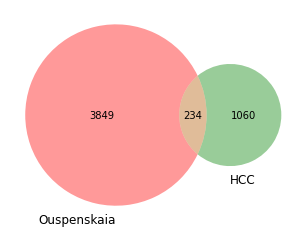

In [36]:
%matplotlib inline

set1 = set(ouspenskaia['trans'])
set2 = set(hcc['trans'])

venn2([set1,set2], ('Ouspenskaia','HCC'))
plt.show()

In [15]:
%matplotlib inline
#how many sequences are supported by both sources of evidence per patient
for p in patients_id:
    ouspenskaia = pd.read_csv(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translation_evidence_ouspenskaia.txt")
    if os.path.getsize(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translation_evidence_hcc.txt") > 1: #is file is not empty
        hcc = pd.read_csv(DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p+"/"+p+"_translation_evidence_hcc.txt")

        set1 = set(ouspenskaia['trans'])
        set2 = set(hcc['trans'])

        venn2([set1,set2], ('Ouspenskaia','HCC'), set_colors=("#fdae6b", "#8856a7"), alpha = 0.7)
        plt.title(p)
        plt.savefig(DIR+"/results/plots/"+p+"_venndiagram_translation_evidence.jpeg")
        plt.close()

In [16]:
#translate
for p in patients_id:
    INDIR=DIR+"/analysis/11_PeptideBindingMHC/translation_evidence_NOCDS/"+p
    file= p + "_translational_evidence.fa"
    outfile = file[:-3] + "_PROTEIN.fa"
    with open (os.path.join(INDIR,outfile), 'w') as out:
        for seq_record in SeqIO.parse(os.path.join(INDIR,file), "fasta"):
            identif=str(seq_record.id)
            sequence=str(seq_record.seq.translate())
            out.write(">" + identif + "\n" + sequence[:-1] + "\n")


**NetMHCpan**

In [ ]:
%%bash -s "$PROJECT" "$DIR" "$CLUSTERDIR" 

######################################DONE IN CLUSTER###############################################

sbatch --array=1-9 $2/scripts/4_neoantigen_prediction/netmhcpan_te.sh $1 $2 $3 #--array=1-n where n is the number of files to process

Exploring netMHCpan output.

Summary file **A** with peptides with binding affinity for at least 1 HLA allele + ENST + ENSG for each canonical / noncanonical with CIPHER / translation evidence 

Summary file **B** how many peptides have binding affinity respect to the total number of peptides

In [5]:
transcript_gene=pd.read_csv(os.path.join(GENOMEDIR,"/biomart.v38.geneid_transid_genetype.csv"),usecols=[0,1], names=['gene_id','ID'], skiprows=1)
INDIR=DIR+"/analysis/11_PeptideBindingMHC"

folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]

for f in folders:
    print(f)
    for p in patients_id:
        print(p)
        full_dir=INDIR+"/"+f+"/"+p
        OUTFILE=full_dir+"/"+p+"_peptides.csv"
        summary_OUTFILE=full_dir+"/"+p+"_summary_total_peptides.csv"
        for file in os.listdir(full_dir):
            if file.endswith(".xls"):
                with open(summary_OUTFILE, 'w') as out:
                    out.write("type,num_peptids,num_peptids_affinity,total\n")
                    netmhcpan=full_dir+"/"+file
                    df = pd.read_csv(netmhcpan, sep="\t",skiprows=1)
                    selected_df = df[['Peptide','ID','NB']]
                    total_peptides = len(selected_df.index)
                    temp = selected_df[selected_df['NB'] > 0]
                    binding_AF = len(temp.index)
                    out.write("%s,%s,%s,total\n"%(f,str(total_peptides),str(binding_AF)))
                    
                    if f == "noncanonical_CIPHER":
                        novel = selected_df[selected_df["ID"].str.contains('STRG')]
                        total_peptidesN = len(novel.index)
                        tempN = novel[novel['NB'] > 0]
                        binding_AFN = len(tempN.index)
                        out.write("%s,%s,%s,novel\n"%(f,str(total_peptidesN),str(binding_AFN)))

                        ENST = selected_df[selected_df["ID"].str.contains('ENST')]
                        total_peptidesK = len(ENST.index)
                        tempK = ENST[ENST['NB'] > 0]
                        binding_AFK = len(tempK.index)
                        out.write("%s,%s,%s,annotated\n"%(f,str(total_peptidesK),str(binding_AFK)))
                              
                              
                    temp_genes = temp.merge(transcript_gene, how='left', on=['ID'])
                    temp_genes.rename(columns={'ID':'transcript_id'}, inplace=True)      
                    temp_genes.to_csv(OUTFILE, index=False)
                    

noncanonical_CIPHER
10615
10594
10584
10635
10632
10628
10627
10622
10619
canonical_CDS
10615
10594
10584
10635
10632
10628
10627
10622
10619
translation_evidence_NOCDS
10615
10594
10584
10635
10632
10628
10627
10622
10619
variant_calling
10615
10594
10584
10635
10632
10628
10627
10622
10619


**C** | general output file with binding affinity information

In [7]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"
folders = [f.name for f in os.scandir(INDIR) if f.is_dir()] #if variant calling is already performed, this line shoul be commented and the next one uncommented
#folders=['noncanonical_CIPHER','canonical_CDS','translation_evidence_NOCDS']

output=INDIR+"/binding_affinity.csv"
absolute_df = pd.DataFrame()

for p in patients_id:
    for f in folders:
        full_dir=INDIR+"/"+f+"/"+p+"/"
        file=full_dir+p+"_summary_total_peptides.csv"
        df = pd.read_csv(file, header=0)
        df['patient'] = p
        absolute_df = pd.concat([absolute_df, df])

cols = list(absolute_df.columns)
cols = [cols[-1]] + cols[:-1]
absolute_df = absolute_df[cols]
absolute_df.to_csv(output, index=False)

At peptide level, are there redundancies? The same peptide several times.

In [8]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"
folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]

for p in patients_id:
    print(p)
    total=pd.DataFrame()
    for f in folders:
        INDIR=DIR+"/analysis/11_PeptideBindingMHC"
        full_dir=INDIR+"/"+f+"/"+p+"/"
        OUTFILE=INDIR+"/"+p+"_total_peptides.csv"
        file=full_dir+p+"_peptides.csv"
        try:
            df = pd.read_csv(file,header=0)
        except:
            print("Patient",p,"has no hits for translation evidence proteins")
        df['method'] = f
        total = pd.concat([total,df],ignore_index=True)
    sorted_df = total.sort_values(by=['Peptide'])
    duplis = sorted_df[sorted_df.duplicated(keep=False)]
    percent=(len(duplis)*100)/len(sorted_df)
    print("DUPLIS: ",len(duplis),"\tTOTAL: ",len(sorted_df)," it represents a: %.2f" %(percent))
    without_duplis=sorted_df.drop_duplicates() #peptides comming from different genes???
    sorted_df.to_csv(OUTFILE, index=False)

10615
DUPLIS:  395 	TOTAL:  145834  it represents a: 0.27
10594
DUPLIS:  427 	TOTAL:  165410  it represents a: 0.26
10584
DUPLIS:  682 	TOTAL:  197697  it represents a: 0.34
10635
DUPLIS:  669 	TOTAL:  203225  it represents a: 0.33
10632
DUPLIS:  567 	TOTAL:  169336  it represents a: 0.33
10628
Patient 10628 has no hits for translation evidence proteins
DUPLIS:  479 	TOTAL:  182478  it represents a: 0.26
10627
DUPLIS:  709 	TOTAL:  285313  it represents a: 0.25
10622
DUPLIS:  486 	TOTAL:  168878  it represents a: 0.29
10619
DUPLIS:  637 	TOTAL:  204657  it represents a: 0.31


## Tissue expression control (GTEx)

GTEx is used as normal control to avoide false positive peptides coming from genes expressed in other healthy tissues 

In [ ]:
%%bash -s "$GENOMEDIR"

cd $1
wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz

In [9]:
GTEx=pd.read_csv(os.path.join(GENOMEDIR,"GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct"), sep="\t", skiprows=2)
GTEx.drop('Description', inplace=True, axis=1)
GTEx['Name'] = GTEx['Name'].str[:-2]
nc = pd.read_csv(DIR+"/analysis/09_CIPHER/common_noncoding_genes.csv")
to_compare = nc.gene_id.values.tolist()

output = DIR+"/analysis/09_CIPHER/common_noncoding_genes_GTEx.csv" #from all the non-protein-coding genes, which ones are present in GTEx

shared = GTEx[GTEx['Name'].isin(to_compare)]
shared.to_csv(output)

c = pd.read_csv(DIR+"/analysis/09_CIPHER/common_coding_genes.csv") #from all the protein-coding genes, which ones are present in GTEx
to_compare_c = c.gene_id.values.tolist()

output_c = DIR+"/analysis/09_CIPHER/common_coding_genes_GTEx.csv"

shared_c = GTEx[GTEx['Name'].isin(to_compare_c)]
shared_c.to_csv(output_c)

In [10]:
%%R -i DIR,GENOMEDIR

#####NONCODING
GTEx_raw = read.csv(paste0(DIR,"/analysis/09_CIPHER/common_noncoding_genes_GTEx.csv"), row.names = 1)
GTEx <- GTEx_raw
GTEx_raw_long <- GTEx %>% pivot_longer(cols=!c("Name"), values_to = "FPKM", names_to = "tissue")
GTEx_raw_long$logFPKM <- log10(GTEx_raw_long$FPKM)
tissue_group <- gsub("\\..*", "", names(GTEx_raw[,2:55]))

temp <- data.frame(tissue_group, names(GTEx_raw[,2:55]))
names(temp)[2] <- "tissue"

GTEx_raw_long <- merge(temp, GTEx_raw_long, by="tissue")

nb.cols <- 54
mycolors <- colorRampPalette(brewer.pal(12, "Paired"))(nb.cols)

ggplot(GTEx_raw_long, aes(x=tissue_group, y=logFPKM, fill=tissue_group))+
  geom_boxplot(show.legend = FALSE) +
  scale_fill_manual(values=mycolors) +
  theme(axis.text.x = element_text(angle = 90, hjust=1))

GTEx$sums <- rowSums(GTEx[,2:55])

GTEx_new <- GTEx[GTEx$sums == 0,]
GTEx <- GTEx[GTEx$sums != 0,]


GTEx_out_FPKM1 <- GTEx[rowSums(GTEx[,2:55] > 1) > 15,]
GTEx_out_FPKM05 <- GTEx[rowSums(GTEx[,2:55] > 0.5) > 15,]

GTEx <- anti_join(GTEx, GTEx_out_FPKM05, by = "Name")
GTEx_long <- GTEx %>% pivot_longer(cols=!c("Name"), values_to = "FPKM", names_to = "tissue")
GTEx_long <- merge(temp, GTEx_long, by="tissue")

not_useful_tissues <- c("Adipose","Adrenal","Artery","Bladder","Breasts","Cells","Cervix","Colon","Esophagus","Fallopian","Heart","Kidney","Liver","Lung","Minor","Muscle","Nerve","Pancreas","Pituitary","Prostate","Skin","Small","Spleen","Stomach","Thyroid","Uterus","Vagina","Whole")
GTEx_long_not_useful <- GTEx_long[GTEx_long$tissue_group %in% not_useful_tissues,] #remove all the genes present in some of the tissue we are not interested in

GTEx_not_useful <- GTEx_long_not_useful[,-c(2,6)] %>% pivot_wider(names_from="tissue", values_from = "FPKM")
GTEx_not_useful$sums <- rowSums(GTEx_not_useful[,2:24])
GTEx_useful <- GTEx_not_useful[GTEx_not_useful$sums == 0,]


####WE ARE INTERESTED IN GTEX_NEW AND GTEX_USEFUL

ids_new <- GTEx_new %>% select(Name)
ids_useful <- GTEx_useful %>% select(Name)
ids <- rbind(ids_new, ids_useful)
names(ids) <- c("gene_id")

trans_gene <- read.csv(paste0(GENOMEDIR,"/biomart.v38.geneid_transid_genetype.csv"))
trans_gene <- trans_gene %>% select(1,3)
names(trans_gene) <- c("gene_id","gene_name")

ids <- merge(ids, trans_gene, by="gene_id")
print(nrow(ids))
print("out of:")
print(nrow(GTEx))

common <- read.csv(paste0(DIR,"/analysis/09_CIPHER/common_noncoding_genes.csv"))
common_ids <- merge(ids, common[,c("transcript_id","gene_id","n")], by="gene_id")

sorted_common_ids <- common_ids[order(common_ids$n, decreasing=TRUE),]
write.table(sorted_common_ids, paste0(DIR,"/analysis/09_CIPHER/common_noncoding_genes_tissues_checked.csv"), col.names=TRUE, row.names=FALSE, quote=FALSE, sep=",")

ggplot(sorted_common_ids, aes(x=n)) +
  geom_bar(fill="#004D40") +
  geom_text(stat="count", aes(label=..count..), vjust=-1, size = 2.5) +
  ggtitle("Common non-coding genes across patients not present in other tissues | lncRNA & processed_pseudogenes") +
  theme(axis.title.x = element_blank(), axis.title.y = element_blank(), plot.title = element_text(face="bold", size = 9), legend.position = "none") 
ggsave(file.path(DIR,"/results/plots/common_noncoding_genes_GTEx_patients.png"))

#####CODING
GTEx_raw = read.csv(paste0(DIR,"/analysis/09_CIPHER/common_coding_genes_GTEx.csv"), row.names = 1)
GTEx <- GTEx_raw
GTEx_raw_long <- GTEx %>% pivot_longer(cols=!c("Name"), values_to = "FPKM", names_to = "tissue")
GTEx_raw_long$logFPKM <- log10(GTEx_raw_long$FPKM)
tissue_group <- gsub("\\..*", "", names(GTEx_raw[,2:55]))

temp <- data.frame(tissue_group, names(GTEx_raw[,2:55]))
names(temp)[2] <- "tissue"

GTEx_raw_long <- merge(temp, GTEx_raw_long, by="tissue")

nb.cols <- 54
mycolors <- colorRampPalette(brewer.pal(12, "Paired"))(nb.cols)

ggplot(GTEx_raw_long, aes(x=tissue_group, y=logFPKM, fill=tissue_group))+
  geom_boxplot(show.legend = FALSE) +
  scale_fill_manual(values=mycolors) +
  theme(axis.text.x = element_text(angle = 90, hjust=1))

GTEx$sums <- rowSums(GTEx[,2:55])

GTEx_new <- GTEx[GTEx$sums == 0,]
GTEx <- GTEx[GTEx$sums != 0,]


GTEx_out_FPKM1 <- GTEx[rowSums(GTEx[,2:55] > 1) > 15,]
GTEx_out_FPKM05 <- GTEx[rowSums(GTEx[,2:55] > 0.5) > 15,]

GTEx <- anti_join(GTEx, GTEx_out_FPKM05, by = "Name")
GTEx_long <- GTEx %>% pivot_longer(cols=!c("Name"), values_to = "FPKM", names_to = "tissue")
GTEx_long <- merge(temp, GTEx_long, by="tissue")

not_useful_tissues <- c("Adipose","Adrenal","Artery","Bladder","Breasts","Cells","Cervix","Colon","Esophagus","Fallopian","Heart","Kidney","Liver","Lung","Minor","Muscle","Nerve","Pancreas","Pituitary","Prostate","Skin","Small","Spleen","Stomach","Thyroid","Uterus","Vagina","Whole")
GTEx_long_not_useful <- GTEx_long[GTEx_long$tissue_group %in% not_useful_tissues,]

GTEx_not_useful <- GTEx_long_not_useful[,-c(2,6)] %>% pivot_wider(names_from="tissue", values_from = "FPKM")
GTEx_not_useful$sums <- rowSums(GTEx_not_useful[,2:24])
GTEx_useful <- GTEx_not_useful[GTEx_not_useful$sums == 0,]


####WE ARE INTERESTED IN GTEX_NEW AND GTEX_USEFUL

ids_new <- GTEx_new %>% select(Name)
ids_useful <- GTEx_useful %>% select(Name)
ids <- rbind(ids_new, ids_useful)
names(ids) <- c("gene_id")

ids <- merge(ids, trans_gene, by="gene_id")
print(nrow(ids))
print("out of:")
print(nrow(GTEx))

common <- read.csv(paste0(DIR,"/analysis/09_CIPHER/common_coding_genes.csv"))
common_ids <- merge(ids, common[,c("transcript_id","gene_id","n")], by="gene_id")

sorted_common_ids <- common_ids[order(common_ids$n, decreasing=TRUE),]
write.table(sorted_common_ids, paste0(DIR,"/analysis/09_CIPHER/common_coding_genes_tissues_checked.csv"), col.names=TRUE, row.names=FALSE, quote=FALSE, sep=",")

ggplot(sorted_common_ids, aes(x=n)) +
  geom_bar(fill="#004D40") +
  geom_text(stat="count", aes(label=..count..), vjust=-1, size = 2.5) +
  ggtitle("Common non-coding genes across patients not present in other tissues | lncRNA & processed_pseudogenes") +
  theme(axis.title.x = element_blank(), axis.title.y = element_blank(), plot.title = element_text(face="bold", size = 9), legend.position = "none") 
ggsave(file.path(DIR,"/results/plots/common_coding_genes_GTEx_patients.png"))



[1] 218
[1] "out of:"
[1] 220


[1] 16
[1] "out of:"
[1] 64


In [11]:
#select peptides resulting from genes not expressed in adult tissues according to GTEx

folders = [f.name for f in os.scandir(INDIR) if f.is_dir()] #if variant calling is already performed, this line shoul be commented and the next one uncommented
#folders=['noncanonical_CIPHER','canonical_CDS','translation_evidence_NOCDS']
for p in patients_id:
    print(p)
    for f in folders:
        print(f)
        if f == "canonical_CDS":
            checked=pd.read_csv(DIR+"/analysis/09_CIPHER/common_coding_genes_tissues_checked.csv", header=0)
            to_compare=checked.gene_id.values.tolist()
        else:
            checked=pd.read_csv(DIR+"/analysis/09_CIPHER/common_noncoding_genes_tissues_checked.csv", header=0)
            to_compare=checked.gene_id.values.tolist()
            
        match=pd.DataFrame()
        INDIR=DIR+"/analysis/11_PeptideBindingMHC/"+f+"/"+p
        filename= p+"_peptides.csv"
        
        outname= p+"_peptides_GTEx.csv" #generate file with those peptides coming from genes that have been selected after GTEx control
        binding_affinity = pd.read_csv(INDIR+"/"+filename)
        match = binding_affinity[binding_affinity['gene_id'].isin(to_compare)]
        try:
            STRG_df = binding_affinity[binding_affinity['transcript_id'].str.contains('STRG')]
            STRG_df['gene_id'] = STRG_df['transcript_id']
            match = pd.concat([match,STRG_df])
        except:
            pass

        match.to_csv(os.path.join(INDIR,outname), index=False)

10615
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10594
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10584
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10635
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10632
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10628
noncanonical_CIPHER
canonical_CDS
translation_evidence_NOCDS
10627
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10622
noncanonical_CIPHER


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


canonical_CDS
translation_evidence_NOCDS
10619
noncanonical_CIPHER
canonical_CDS
translation_evidence_NOCDS


/tmp/ipykernel_10294/3295328720.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  STRG_df['gene_id'] = STRG_df['transcript_id']


Exploring netMHCpan output with GTEx filter

Summary file **A** how many peptides have binding affinity respect to the total number of peptides

In [12]:
transcript_gene=pd.read_csv(os.path.join(GENOMEDIR,"/biomart.v38.geneid_transid_genetype.csv"),usecols=[0,1], names=['gene_id','ID'], skiprows=1)
INDIR=DIR+"/analysis/11_PeptideBindingMHC"

#folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]
folders=['noncanonical_CIPHER','canonical_CDS','translation_evidence_NOCDS']

for f in folders:
    print(f)
    for p in patients_id:
        print(p)
        full_dir=INDIR+"/"+f+"/"+p
        gtex_file=full_dir+"/"+p+"_peptides_GTEx.csv"
        summary_OUTFILE=full_dir+"/"+p+"_summary_total_peptides_GTEx.csv"
        file=p+"_summary_total_peptides.csv"
        with open(summary_OUTFILE, 'w') as out:
            out.write("type,num_peptids,num_peptids_affinity,total\n")
            full_summary=full_dir+"/"+file
            df = pd.read_csv(full_summary, header=0)
            total_df = df[df["total"] == 'total']
            total_peptides = total_df.iat[0,1]


            gtex_df = pd.read_csv(gtex_file, header=0)
            peptides = gtex_df.Peptide.values.tolist()
            binding_AF = len(gtex_df.index)
            out.write("%s,%s,%s,total\n"%(f,str(total_peptides),str(binding_AF)))

            if f == "noncanonical_CIPHER":
                print(df)
                novel = df[df["total"] == 'novel']
                total_peptidesN = novel.iat[0,1]
                novel_gtex = gtex_df[gtex_df['transcript_id'].str.contains('STRG')]
                binding_AFN = len(novel_gtex.index)
                out.write("%s,%s,%s,novel\n"%(f,str(total_peptidesN),str(binding_AFN)))

                ENST = df[df["total"] == 'annotated']
                total_peptidesK = ENST.iat[0,1]

                enst_gtex = gtex_df[gtex_df['transcript_id'].str.contains('ENST')]
                binding_AFK = len(enst_gtex.index)
                out.write("%s,%s,%s,annotated\n"%(f,str(total_peptidesK),str(binding_AFK)))

                    

noncanonical_CIPHER
10615
                  type  num_peptids  num_peptids_affinity      total
0  noncanonical_CIPHER      1131199                141076      total
1  noncanonical_CIPHER          229                    19      novel
2  noncanonical_CIPHER      1130970                141057  annotated
10594
                  type  num_peptids  num_peptids_affinity      total
0  noncanonical_CIPHER      1134382                158852      total
1  noncanonical_CIPHER         7016                  1056      novel
2  noncanonical_CIPHER      1127366                157796  annotated
10584
                  type  num_peptids  num_peptids_affinity      total
0  noncanonical_CIPHER      1161637                186978      total
1  noncanonical_CIPHER          592                    88      novel
2  noncanonical_CIPHER      1161045                186890  annotated
10635
                  type  num_peptids  num_peptids_affinity      total
0  noncanonical_CIPHER      1033621                201101  

**C** | general output file with binding affinity information

In [13]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"
folders = [f.name for f in os.scandir(INDIR) if f.is_dir()]
#folders=['noncanonical_CIPHER','canonical_CDS','translation_evidence_NOCDS']

output=INDIR+"/binding_affinity_GTEx.csv"
absolute_df = pd.DataFrame()

for p in patients_id:
    for f in folders:
        full_dir=INDIR+"/"+f+"/"+p+"/"
        
        file=full_dir+p+"_summary_total_peptides_GTEx.csv"
        df = pd.read_csv(file, header=0)

        df['patient'] = p
        absolute_df = pd.concat([absolute_df, df])

cols = list(absolute_df.columns)
cols = [cols[-1]] + cols[:-1]
absolute_df = absolute_df[cols]
absolute_df.to_csv(output, index=False)

Exploring novel peptides shared between patients 

In [14]:
INDIR=DIR+"/analysis/11_PeptideBindingMHC"

total_peptides_df = pd.DataFrame()
for p in patients_id:
    print(p)
    peptides = pd.read_csv(INDIR+"/"+p+"_total_peptides.csv")
    try:
        novel_peptides = peptides[peptides['transcript_id'].str.contains('STRG')]
        novel_peptides['gene_id'] = novel_peptides['transcript_id']
        novel_peptides_df = novel_peptides['Peptide']
        print("with duplis: ",len(novel_peptides_df))

        novel_peptides_df = novel_peptides_df.drop_duplicates()
        print("without duplis: ",len(novel_peptides_df))
        total_peptides_df= pd.concat([total_peptides_df, novel_peptides_df])
    except:
        print("Patient ",p," has no novel peptides.")

total_peptides_counts = total_peptides_df.value_counts().rename_axis('peptide').reset_index(name='counts')



10615


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  19
without duplis:  19
10594


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  1056
without duplis:  1054
10584


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  88
without duplis:  88
10635


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  329
without duplis:  316
10632


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  18
without duplis:  18
10628
with duplis:  0
without duplis:  0
10627


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  134
without duplis:  134
10622


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


with duplis:  1236
without duplis:  1154
10619
with duplis:  48
without duplis:  48


/tmp/ipykernel_10294/3160070270.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel_peptides['gene_id'] = novel_peptides['transcript_id']


In [19]:
total_peptides_counts.to_csv(DIR+"/analysis/novel_neoantigens.csv", index=False)
total_peptides_counts

,peptide,counts
0,KGDDENKRI,3
1,DEIVYNCQI,3
2,REDFRCTLI,2
3,RPQPPGTQA,2
4,VEFQLQSHL,2
...,...,...
2756,KDNGDTDLF,1
2757,KDYDLACLL,1
2758,KEAKNLHKR,1
2759,KECGSGLML,1
